In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from harmonic_mixture_sampler import GaussianMixtureSwapper
from bayes_adaptive_fitter import MultinomialBayes

# Bayesian estimation of normalizing constants

The tools demonstrated in this notebook, particularly the `MultinomialBayes` class, are designed to infer the relative ratios of normalizing constants of mixture distributions of the following form:

$$ p(x, l=i| \zeta) = \frac{q_i(x)\exp(\zeta_i)}{\sum^K_{j=1}Z_j\exp(\zeta_i)} $$

where $x$ is the configuration, $i$ the state, the number of distributions in the mixture is $K$, $\zeta_i$ is a user defined biasing potential, $q_i(x)$ is the unnormalized density of the $i$th distribution, and $Z_i$ is the respective normalizing constant. We are concerned with estimating the ratios $Z_i/Z_0 \, \forall i$. 

By defining the free energy of the $i$th state as

$$ f_i = -\ln(Z_i) $$

we can write the marginal of $p(x, l=i| \zeta)$ over $x$ as 

$$ p(l=i | \zeta) = \frac{\exp(\zeta_i - f_i)}{\sum_{j=1}^{K} \exp(\zeta_j - f_j)} $$

This marginal is a multinomial distribution over the states, which allows for Bayesian inference of the $f_i$s (and thus $Z_i$) relative to the 0th state. The `MultinomialBayes` class is designed for such distributions, takes as input the counts in each state and the applied biases to return Bayesian estimates of the relative $f_i$s.

To demonstrate and test it's functionality, a Gaussian mixture sampler class, called `GaussianMixtureSwapper` was written, where each $q_i(x)$ is an unnormalized Gaussian distribution. To generate the data for the `MultinomialBayes` example, this notebook will start by with a `GaussianMixtureSwapper` example.

## Example of `GaussianMixtureSwapper` 
### Mixture of 4 Gaussian distributions

The standard deviations of the Guassians are:

In [2]:
sigmas = np.array((1.0, 10.0, 20.0, 30.0))

The set of biasing potentials for each state are

In [3]:
zetas = np.array((0., 0., 0., 0.))

Initializing the mixture sampler:

In [4]:
sampler = GaussianMixtureSwapper(sigmas=sigmas, zetas=zetas)

Sample positions and states for 10000 iterations, and record the state of the sampler every 50 moves:

In [5]:
sampler.sample_mixture(niterations=10000, save_freq=50)
print 'Number of times in each state:', sampler.state_counter

Number of times in each state: [  5.  35.  63.  97.]


These counts be used to estimate the relative normalizing constants of each states using `MultinomialBayes`.

## Example of `MultinomialBayes` 
### Applied to mixture of 4 Gaussian distributions

Using the state counts from the above example to demonstrate the main functionality of `MultinomialBayes`.

Initializing the class with the counts and biases. The prior for the normalizing constants is also supplied.

In [6]:
fitter = MultinomialBayes(zetas=zetas, counts=sampler.state_counter, prior='gaussian', spread=5.0, location=0.0)

Sample values of the free energies (excluding the first state) from the posterior density using `emcee`. Selecting the number of walkers and moves. 

In [7]:
samples = fitter.sample_posterior(nwalkers=50, nmoves=1000)

In [8]:
print samples.shape

(50, 1000, 3)


The samples have 1000 samples from each of the 50 walkers, for each free energy (3). While there are 4 states in total, the all free energies are relative to the first state, so there are only 3 free parameters. 

Viewing the traces for the first 3 walkers for the first free energy

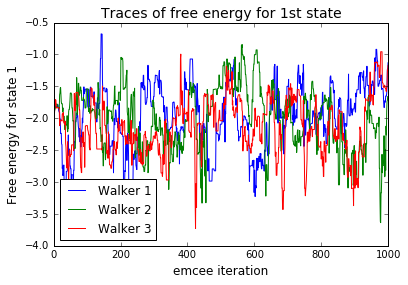

In [9]:
samps_walker1 = samples[0,:,0]
samps_walker2 = samples[1,:,0]
samps_walker3 = samples[2,:,0]

plt.plot(samps_walker1)
plt.plot(samps_walker2)
plt.plot(samps_walker3)
plt.legend(('Walker 1','Walker 2', 'Walker 3'), loc=3)
plt.title('Traces of free energy for 1st state', fontsize=14)
plt.ylabel('Free energy for state 1', fontsize=12)
plt.xlabel('emcee iteration', fontsize=12)
plt.show()

Viewing histograms for each free energy. Arbitrarily discarding the first 50 samples as 'burn-in', and collecting all the walkers into a single vector for each free energy.

In [10]:
flat_samples = samples[:, 50:, :].reshape((-1, 3))
print 'New sample dimensions:', flat_samples.shape

New sample dimensions: (47500, 3)


In [11]:
# # These are the "Tableau" colors as RGB. Taken on 26th Nov 2015 from:
#http://tableaufriction.blogspot.co.uk/2012/11/finally-you-can-use-tableau-data-colors.html
# In order: blue, green, purple, orange. Hopefully a good compromise for colour-blind people.
tableau4 = [(31, 119, 180),(44, 160, 44),(148,103,189),(255, 127, 14)]
tableau4_light = [(174,199,232),(152,223,138),(197,176,213),(255,187,120)]

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts. 
for i in range(len(tableau4)):    
    r, g, b = tableau4[i]    
    tableau4[i] = (r / 255., g / 255., b / 255.)
    r, g, b = tableau4_light[i]    
    tableau4_light[i] = (r / 255., g / 255., b / 255.)

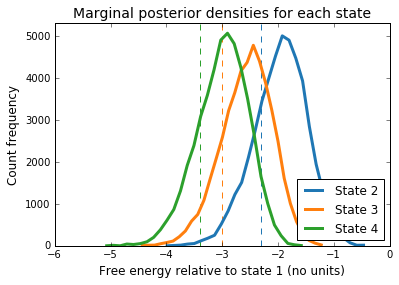

In [12]:
def histomatic(data, nbins=30):
    """
    Wrapper to histogram data for easy ploting.
    """
    counts, bins = np.histogram(data, nbins)
    midpoints = bins[0:len(bins)-1] + np.diff(bins)/2.0
    return midpoints, counts

plt.clf()
cnts = []  # To store all the counts
mode = []  # To store the modes
colors = (tableau4[0],tableau4[3],tableau4[1])
for i in (0,1,2):
    # Plotting the histogram
    midpoints, counts = histomatic(flat_samples[:,i])
    plt.plot(midpoints, counts, lw=3, color=colors[i])
    # Saving the mode for each state
    mode.append(midpoints[np.where(counts == counts.max())][0])
    # Recording the counts to help with plotting limit
    cnts.append(counts)

# Setting the limits
ymax = np.max(cnts)+0.05*np.max(cnts)
plt.ylim(0,ymax)

plt.title('Marginal posterior densities for each state', fontsize=14)
plt.legend(('State 2','State 3', 'State 4'), loc=4)
plt.xlabel('Free energy relative to state 1 (no units)', fontsize=12)
plt.ylabel('Count frequency', fontsize=12)
plt.vlines(x=-np.log(sigmas/sigmas[0])[1:], ymin=0, ymax=ymax, color=colors, linestyle='--')
plt.show()

The true (relative) free energy is shown in the dotted line. 

To be clear, the above shows the marginal free energies for each state, whose modes may differ from the MAP estimate.

In [13]:
from copy import deepcopy
mode_estimate = np.hstack((0,mode))
map_estimate = fitter.max_a_post(f_guess=deepcopy(mode_estimate), max_iter=10000)

In [14]:
print 'Marginal modes:', mode_estimate
print 'MAP estimate:  ', map_estimate
print 'St. dev.:      ', np.hstack((0,flat_samples.std(axis=0)))
print 'True values:   ', -np.log(sigmas/sigmas[0])

Marginal modes: [ 0.         -1.92156219 -2.44050212 -2.90361791]
MAP estimate:   [ 0.         -1.59775147 -1.40080632 -3.6385204 ]
St. dev.:       [ 0.          0.47475078  0.45938886  0.46006543]
True values:    [-0.         -2.30258509 -2.99573227 -3.40119738]


### Adding new samples from mixture
One can also input data from multiple experiments into `MultinomialBayes`. For example, based on the results of the previous calculations, we can set new biases for a new round of data collection. By setting the biases equal to the estimated free energies, we should be able to approximately sample uniformly over the states:

In [15]:
new_zetas = map_estimate   # Setting the zetas to the MAP estimates
new_sampler = GaussianMixtureSwapper(sigmas=sigmas, zetas=new_zetas)
new_sampler.sample_mixture(niterations=10000, save_freq=50)
print 'Number of times in each state:', new_sampler.state_counter

Number of times in each state: [  25.   39.  115.   21.]


These new biases and counts must be combined with the old counts:

In [16]:
combined_zetas = np.vstack((zetas, new_zetas))
combined_counts = np.vstack((sampler.state_counter, new_sampler.state_counter))

And the Bayesian inference is performed again. Below, the previous MAP estimate as the starting point of the Bayesian sampling.

In [17]:
comb_fitter = MultinomialBayes(zetas=combined_zetas, counts=combined_counts, prior='gaussian', spread=5.0, location=0.0)
new_samples = comb_fitter.sample_posterior(f_guess=map_estimate, nwalkers=50, nmoves=1000)
flat_samples = new_samples[:, 50:, :].reshape((-1, 3))

Plotting the latest results

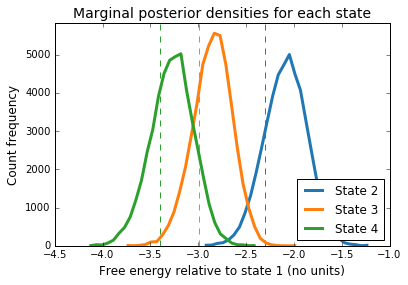

In [18]:
plt.clf()
cnts = []  # To store all the counts
mode = []  # To store the modes
colors = (tableau4[0],tableau4[3],tableau4[1])
for i in (0,1,2):
    # Plotting the histogram
    midpoints, counts = histomatic(flat_samples[:,i])
    plt.plot(midpoints, counts, lw=3, color=colors[i])
    # Saving the mode for each state
    mode.append(midpoints[np.where(counts == counts.max())][0])
    # Recording the counts to help with plotting limit
    cnts.append(counts)

# Setting the limits
ymax = np.max(cnts)+0.05*np.max(cnts)
plt.ylim(0,ymax)

plt.title('Marginal posterior densities for each state', fontsize=14)
plt.legend(('State 2','State 3', 'State 4'), loc=4)
plt.xlabel('Free energy relative to state 1 (no units)', fontsize=12)
plt.ylabel('Count frequency', fontsize=12)
plt.vlines(x=-np.log(sigmas/sigmas[0])[1:], ymin=0, ymax=ymax, color=colors, linestyle='--')
plt.show()

In [19]:
mode_estimate = np.hstack((0,mode))
map_estimate = fitter.max_a_post(f_guess=deepcopy(mode_estimate), max_iter=10000)

print 'Marginal modes:', mode_estimate
print 'MAP estimate:  ', map_estimate
print 'St. dev.:      ', np.hstack((0,flat_samples.std(axis=0)))
print 'True values:   ', -np.log(sigmas/sigmas[0])

Marginal modes: [ 0.         -2.04690121 -2.83141354 -3.18042225]
MAP estimate:   [ 0.         -2.04650755 -2.83975346 -1.71638186]
St. dev.:       [ 0.          0.22348589  0.20476303  0.22357003]
True values:    [-0.         -2.30258509 -2.99573227 -3.40119738]


The new estimates are now have a lower bias and variance than before.